# Decision Tree Classifier Assignment
**Name: Adham Ali**  
**ID: 5703031**  
**Date: 03/11/2025**

In this notebook, I will:
- Load the Census-Income dataset
- Preprocess the data (handle categorical features, clean missing values, etc.)
- Train a Decision Tree with `max_depth=3`
- Evaluate the model using accuracy, precision, recall, and F1-score
- Visualize the Decision Tree
- Discuss feature importance
- Finally, test the model on a separate test dataset.



In [28]:
##Libraries Needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder



### 1. Data Loading and Preprocessing
In this section, we load the dataset using pandas and assign the appropriate column names. We also handle missing values and convert categorical features into numerical format via one-hot encoding. Finally, we display the first few rows of the processed data.


In [29]:
# Define the column names based on the dataset description
col_names = [
    "age", "worker_class", "ind_code", "occ_code", "education",
    "wage", "edu_enrolled", "marital_status", "maj_ind_code",
    "maj_occ_code", "race", "hispanic", "sex", "lab_union",
    "unemp_reason", "employment_status", "cap_gains",
    "cap_losses", "dividends", "tax_status",
    "prev_res_region", "prev_res_state",
    "household_status", "household_summary",
    "mig_code_MSA", "mig_code_region",
    "mig_code_move", "lived_in_house",
    "mig_prev_sunbelt", "num_emp",
    "fam_under18", "birth_country_father",
    "birth_country_mother", "birth_country_self", "citizenship",
    "self_employed", "vet_questionnaire",
    "vet_benefits", "weeks_worked", "year", "income"
]

# Load the training and test datasets without headers using the defined column names
train_df = pd.read_csv("census-income.data", header=None, names=col_names)
test_df = pd.read_csv("census-income.test", header=None, names=col_names)

# Remove extra whitespace from string columns to ensure consistent formatting
train_df = train_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
test_df = test_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Convert specified numeric columns to numeric data types, coercing any conversion errors to NaN
num_cols = ["age", "wage", "cap_gains", "cap_losses", "dividends", "weeks_worked"]
train_df[num_cols] = train_df[num_cols].apply(pd.to_numeric, errors='coerce')
test_df[num_cols] = test_df[num_cols].apply(pd.to_numeric, errors='coerce')

# Standardize the income labels for consistency
train_df["income"] = train_df["income"].replace({"- 50000.": "≤50K", "50000+": ">50K"})
test_df["income"] = test_df["income"].replace({"- 50000.": "≤50K", "50000+": ">50K"})

# Replace placeholder values ("Not in universe") with NA to handle missing data properly
train_df.replace("Not in universe", pd.NA, inplace=True)
test_df.replace("Not in universe", pd.NA, inplace=True)

# Fill missing values:
# For categorical columns, use the mode (most frequent value)
# For numerical columns, use the median value
for col in train_df.columns:
    if train_df[col].dtype == "object":
        mode_value = train_df[col].mode()[0]
        train_df[col] = train_df[col].fillna(mode_value)
        test_df[col] = test_df[col].fillna(mode_value)
    else:
        median_value = train_df[col].median()
        train_df[col] = train_df[col].fillna(median_value)
        test_df[col] = test_df[col].fillna(median_value)

# Get all categorical columns except 'income
cat_cols = [col for col in train_df.select_dtypes(include=['object']).columns if col != "income"]

# Perform one-hot encoding on categorical columns to convert them into numerical features
train_enc = pd.get_dummies(train_df, columns=cat_cols)
test_enc = pd.get_dummies(test_df, columns=cat_cols)

# Ensure that the test dataset has the same columns as the training dataset
missing_cols = set(train_enc.columns) - set(test_enc.columns)
for col in missing_cols:
    test_enc[col] = 0
# Reorder test_enc columns to match train_enc
test_enc = test_enc[train_enc.columns]

# Display the first few rows and the shape of the processed datasets
print("First 5 rows of processed training data:")
display(train_enc.head())
print("Train shape:", train_enc.shape)
print("Test shape:", test_enc.shape)


First 5 rows of processed training data:


,age,worker_class,ind_code,education,wage,employment_status,cap_gains,cap_losses,dividends,household_summary,...,birth_country_self_United-States,birth_country_self_Vietnam,birth_country_self_Yugoslavia,citizenship_Foreign born- Not a citizen of U S,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States,vet_questionnaire_No,vet_questionnaire_Yes
73,NaN,0,0,0,NaN,0,0,0,NaN,1700.09,...,True,False,False,False,False,False,False,True,True,False
58,NaN,4,34,0,NaN,0,0,0,NaN,1053.55,...,True,False,False,False,False,False,False,True,True,False
18,NaN,0,0,0,NaN,0,0,0,NaN,991.95,...,False,True,False,True,False,False,False,False,True,False
9,NaN,0,0,0,NaN,0,0,0,NaN,1758.14,...,True,False,False,False,False,False,False,True,True,False
10,NaN,0,0,0,NaN,0,0,0,NaN,1069.16,...,True,False,False,False,False,False,False,True,True,False


Train shape: (199523, 383)
Test shape: (99762, 383)


### 2. Splitting the Data and Training the Model
Here, we separate the dataset into features (X) and labels (y). Then, we split the data into training and testing sets using a 70:30 ratio. We train a Decision Tree Classifier (with max_depth=3) on the training set and evaluate its performance using metrics such as accuracy, precision, recall, and F1-score.


In [30]:
# Separate features (X) and target label (y) from the training data
X = train_enc.drop("income", axis=1)
y = train_enc["income"]

# Split the training dataset into training and validation sets (70% training, 30% validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Decision Tree Classifier with a maximum depth of 3 (to reduce overfitting)
dt_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
# Train the classifier on the training data
dt_clf.fit(X_train, y_train)

# Predict the income classes on the validation set
y_pred = dt_clf.predict(X_test)

# Evaluate the model using accuracy and a detailed classification report (precision, recall, F1-score)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy on validation set:", accuracy)
print("Classification Report on validation set:")
print(report)

Accuracy on validation set: 0.9465392518836561
Classification Report on validation set:
              precision    recall  f1-score   support

     50000+.       0.77      0.15      0.26      3582
        ≤50K       0.95      1.00      0.97     56275

    accuracy                           0.95     59857
   macro avg       0.86      0.58      0.61     59857
weighted avg       0.94      0.95      0.93     59857



### 3. Visualizing the Decision Tree
In this section, we generate both a textual representation (using export_text) and a graphical visualization (using plot_tree) of the trained Decision Tree. This visualization helps us understand which features the model uses to make decisions and how the tree is structured.


Decision Tree Rules:
|--- employment_status <= 7364.00
|   |--- weeks_worked <= 47.50
|   |   |--- cap_losses <= 12689.50
|   |   |   |--- class: ≤50K
|   |   |--- cap_losses >  12689.50
|   |   |   |--- class: ≤50K
|   |--- weeks_worked >  47.50
|   |   |--- ind_code <= 18.50
|   |   |   |--- class: ≤50K
|   |   |--- ind_code >  18.50
|   |   |   |--- class: ≤50K
|--- employment_status >  7364.00
|   |--- employment_status <= 10041.00
|   |   |--- employment_status <= 7792.00
|   |   |   |--- class: 50000+.
|   |   |--- employment_status >  7792.00
|   |   |   |--- class: ≤50K
|   |--- employment_status >  10041.00
|   |   |--- hispanic_Female <= 0.50
|   |   |   |--- class: 50000+.
|   |   |--- hispanic_Female >  0.50
|   |   |   |--- class: 50000+.

Decision Tree Classes: ['50000+.', '≤50K']


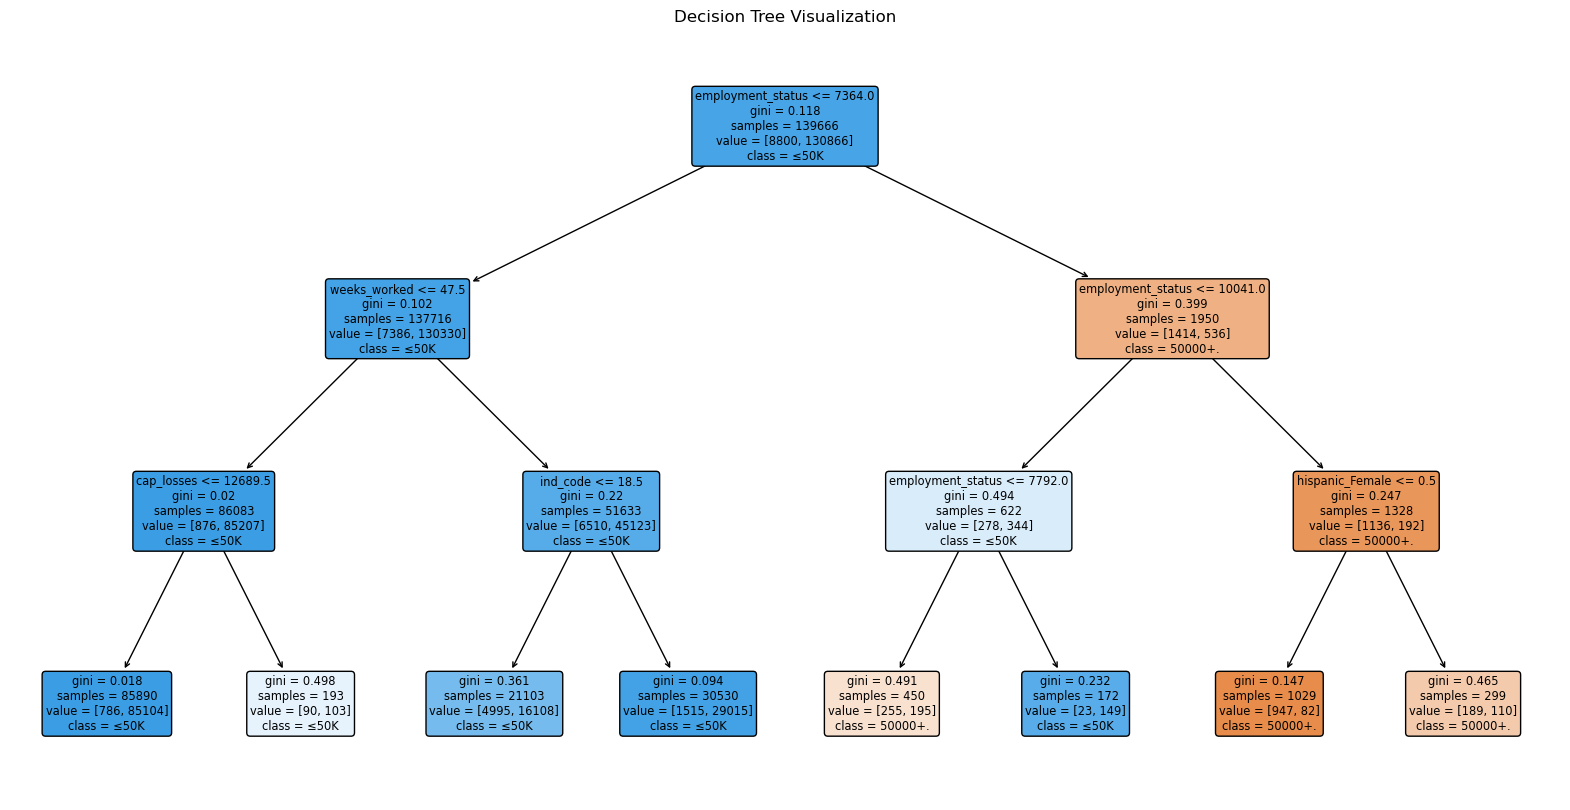

In [31]:
# Create a list of feature names (converted to strings for visualization)
feature_names = [str(col) for col in X.columns]

# Generate a textual representation of the decision tree rules for interpretability
tree_rules = export_text(dt_clf, feature_names=feature_names)
print("Decision Tree Rules:")
print(tree_rules)

# Prepare class names for visualization (as strings)
class_names = [str(cls) for cls in dt_clf.classes_]
print("Decision Tree Classes:", class_names)

# Plot the decision tree using matplotlib for a visual understanding of splits and nodes
plt.figure(figsize=(20, 10))
plot_tree(
    dt_clf,
    filled=True,
    feature_names=feature_names,
    class_names=class_names,
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()

### 4. Feature Importance
We retrieve the feature importance scores from the trained Decision Tree and display them in both tabular and graphical formats. A separate discussion (included in a text cell) explains why certain features may appear as the most important, based on the nature of the dataset and the model's structure.


Feature Importances (All Features):
                                  Feature  Importance
5                       employment_status    0.508261
2                                ind_code    0.230957
13                           weeks_worked    0.229318
7                              cap_losses    0.021286
92                        hispanic_Female    0.010178
..                                    ...         ...
126               prev_res_region_Georgia    0.000000
125               prev_res_region_Florida    0.000000
124  prev_res_region_District of Columbia    0.000000
123              prev_res_region_Delaware    0.000000
134                 prev_res_region_Maine    0.000000

[382 rows x 2 columns]


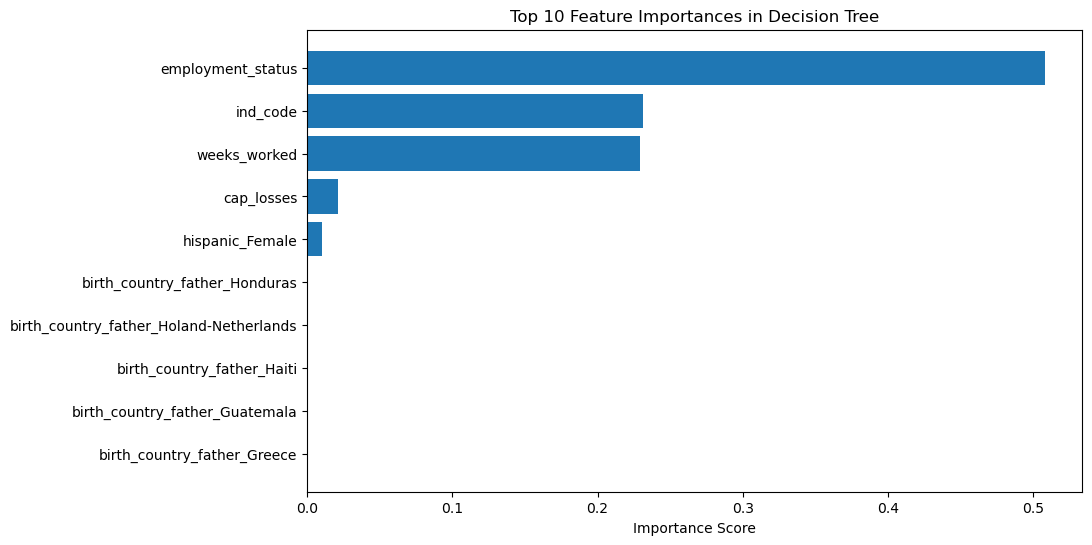

In [32]:
# Retrieve feature importance scores from the trained model
importances = dt_clf.feature_importances_
features = X.columns

# Create a DataFrame to store features and their corresponding importance scores
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort features by importance in descending order to highlight the most significant ones
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print("Feature Importances (All Features):")
print(importance_df)

# Plot the top 10 most important features using a horizontal bar chart
top_n = 10
top_features = importance_df.head(top_n)
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()  # Invert y-axis so that the most important feature is at the top
plt.title(f"Top {top_n} Feature Importances in Decision Tree")
plt.xlabel("Importance Score")
plt.show()

### Detailed Discussion on Feature Importance

In our Decision Tree model, one feature, for example,  **employment_status**, is the most significant. The reason can be explained intuitively by considering both the nature of the Census Income dataset and the features of our model:

#### Direct Association with Income:
The **employment_status** attribute directly indicates whether a person is employed, which is a strong predictor of income level. Most often, a consistent employment status is associated with a greater chance of earning over the income cutoff, so this attribute is highly predictive.

#### Effect of One-Hot Encoding:
The data set contains many categorical variables that have been translated into multiple binary columns through one-hot encoding. Even though some columns are created from the same variable, the model can learn that one particular dummy variable (e.g., for a particular employment class) will result in a more discriminative, more decisive split in the data.


#### Model Structure Constraints:
Our tree is configured with a shallow maximum depth (max_depth=3). This limitation will force the model to concentrate on the features with the largest decrease in impurity. In our example, **employment_status** can account for most of the variance in income classification towards the beginning of the tree and be assigned a higher importance value.

#### Interpretability and Feature Selection:
The high importance of **employment_status** indicates to us that the model is making very strong predictions based on this attribute. Although this makes the model easier to interpret, it also indicates to us that, in our current configuration, the model is exploiting the most straightforward and uniform predictor. If we allowed a more complicated tree or used ensemble methods (like Random Forests), we might see a more dispersed importance among other features.

On a general scale, the predominance of **employment_status** (or any other determining feature) at the top in our feature importance ranking is not only a result of its exceptional explanatory power relative to income prediction but also an effect of the structural constraints of the model. It makes intuitive sense considering employment status is one of the determinant factors for someone's income level.


### 5. Evaluation on the Test Set
Finally, we use the trained model to predict labels for the separate test dataset. We then calculate and display evaluation metrics—including accuracy, precision, recall, and F1-score—using the classification report and accuracy score. This step assesses how well our model generalizes to unseen data.


In [33]:
# Prepare the test dataset by separating features and labels
X_test_final = test_enc.drop("income", axis=1)
y_test_final = test_enc["income"]

# Use the trained model to predict income classes for the test dataset
y_pred_final = dt_clf.predict(X_test_final)

# Compute evaluation metrics (accuracy, precision, recall, F1-score) for the test set
accuracy_test = accuracy_score(y_test_final, y_pred_final)
report_test = classification_report(y_test_final, y_pred_final)
print("Accuracy on the Separate Test Set:", accuracy_test)
print("Classification Report on the Separate Test Set:")
print(report_test)


Accuracy on the Separate Test Set: 0.9446482628656202
Classification Report on the Separate Test Set:
              precision    recall  f1-score   support

     50000+.       0.77      0.15      0.26      6186
        ≤50K       0.95      1.00      0.97     93576

    accuracy                           0.94     99762
   macro avg       0.86      0.57      0.61     99762
weighted avg       0.94      0.94      0.93     99762

